# CSYE 7105 - High Perfoamnce Machine Learning & AI - Project - Team 4 

## Analysis of Efficient Parallel Computing for Deep Learning-Based Glaucoma Detection

### Serial Execution using GPU with different Batch Size

#### Importing necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
import os
import socket
import time
import json
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
import logging
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)

#### Defining the Glaucoma - Medical CNN model from scratch

This MedicalCNN model, with 129 layers, uses a combination of convolutional, residual, multi-dilated, and fully connected blocks, tailored for glaucoma classification. I’ve included Residual Blocks to help with vanishing gradients, MultiDilated Blocks for enhanced feature extraction, and Squeeze-and-Excitation (SE) Blocks to fine-tune feature importance across channels.

In [2]:
class GlaucomaDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        image = torch.from_numpy(image).float()
        if len(image.shape) == 3:
            image = image.permute(2, 0, 1)  # (H,W,C) -> (C,H,W)
        if self.transform:
            image = self.transform(image)
        return image, label

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                              stride=stride, padding=padding, bias=False, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=False),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity
        out = self.relu(out)
        return out

class MultiDilatedBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiDilatedBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels//4, kernel_size=3, padding=1, dilation=1)
        self.conv2 = ConvBlock(in_channels, out_channels//4, kernel_size=3, padding=2, dilation=2)
        self.conv3 = ConvBlock(in_channels, out_channels//4, kernel_size=3, padding=3, dilation=3)
        self.conv4 = ConvBlock(in_channels, out_channels//4, kernel_size=3, padding=4, dilation=4)
        self.conv_fusion = ConvBlock(out_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x = torch.cat([x1, x2, x3, x4], dim=1)
        return self.conv_fusion(x)

class MedicalCNN(nn.Module):
    def __init__(self, num_classes=2, base_filters=64):
        super(MedicalCNN, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_filters, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_stage(base_filters, base_filters, blocks=3)
        self.stage2 = self._make_stage(base_filters, base_filters*2, blocks=4, stride=2)
        self.stage3_res = self._make_stage(base_filters*2, base_filters*4, blocks=6, stride=2)
        self.stage3_md = MultiDilatedBlock(base_filters*4, base_filters*4)
        self.stage4_res = self._make_stage(base_filters*4, base_filters*8, blocks=3, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(base_filters*8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=False),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=False),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self._initialize_weights()
    
    def _make_stage(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3_res(x)
        x = self.stage3_md(x)
        x = self.stage4_res(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def count_layers(self):
        stem_layers = 4
        stage1_layers = 3 * 6
        stage2_layers = 4 * 6
        stage3_layers = 6 * 6 + 10
        stage4_layers = 3 * 6 + 10
        fc_layers = 9
        total_layers = stem_layers + stage1_layers + stage2_layers + stage3_layers + stage4_layers + fc_layers
        return total_layers

def get_medical_transforms():
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform


#### Defining the functions to train the model in 1GPU without DDP or other parallelization techniques

In [3]:
# Logging setup
logging.basicConfig(
    level=logging.INFO,  # Set the logging level to INFO
    format='%(asctime)s - %(levelname)s - %(message)s', 
    handlers=[
        logging.FileHandler("logs/training_using_gpus_1_logs_batch_size.txt"),
        logging.StreamHandler()  # Also log to console
    ]
)

def train_and_evaluate_with_batch_size(data_dir, batch_size):
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    logging.info(f"Loading data with batch size {batch_size}...")
    X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
    y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
    X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
    y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
    
    logging.info(f"Data shapes: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
    
    train_transform, val_transform = get_medical_transforms()
    
    train_dataset = GlaucomaDataset(X_train, y_train, transform=train_transform)
    val_dataset = GlaucomaDataset(X_val, y_val, transform=val_transform)
    test_dataset = GlaucomaDataset(X_test, y_test, transform=val_transform)
    
    # Create data loaders for the given batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # Model setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MedicalCNN(num_classes=2)
    model = model.to(device)
    
    # Criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Training loop
    start_time = time.time()
    best_val_acc = 0.0
    for epoch in range(10):  # Training for 10 epochs
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train_samples = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * data.size(0)
            total_train_samples += data.size(0)
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == target).sum().item()
        
        train_loss = epoch_train_loss / total_train_samples
        train_accuracy = 100.0 * correct_train / total_train_samples
        logging.info(f'Epoch [{epoch+1}/10], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        correct_val = 0
        total_val_samples = 0
        all_targets = []
        all_probabilities = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                epoch_val_loss += loss.item() * data.size(0)
                total_val_samples += data.size(0)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == target).sum().item()
                all_targets.extend(target.cpu().numpy())
                all_probabilities.extend(F.softmax(output, dim=1).cpu().numpy())
        
        val_loss = epoch_val_loss / total_val_samples
        val_accuracy = 100.0 * correct_val / total_val_samples
        logging.info(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict().copy()
    
    total_time = time.time() - start_time
    logging.info(f"Training completed for batch size {batch_size} in {total_time:.2f} seconds")

    # Testing
    model.load_state_dict(best_model_state)
    model.eval()
    epoch_test_loss = 0.0
    correct_test = 0
    total_test_samples = 0
    all_test_targets = []
    all_test_probabilities = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_test_loss += loss.item() * data.size(0)
            total_test_samples += data.size(0)
            _, predicted = torch.max(output, 1)
            correct_test += (predicted == target).sum().item()
            all_test_targets.extend(target.cpu().numpy())
            all_test_probabilities.extend(F.softmax(output, dim=1).cpu().numpy())
    
    test_loss = epoch_test_loss / total_test_samples
    test_accuracy = 100.0 * correct_test / total_test_samples
    try:
        test_auc = roc_auc_score(np.array(all_test_targets), np.array(all_test_probabilities)[:, 1])
    except Exception as e:
        logging.error(f"Error calculating Test AUC-ROC: {e}")
        test_auc = None

    logging.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    if test_auc is not None:
        logging.info(f"Test AUC-ROC: {test_auc:.4f}")

    return {
        'batch_size': batch_size,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'training_time': total_time
    }

#### Main function to handle and call all the functional flow

2025-04-05 00:45:30,813 - INFO - Training with batch size 16...
2025-04-05 00:45:30,835 - INFO - Loading data with batch size 16...
2025-04-05 00:45:44,170 - INFO - Data shapes: Train (23898, 224, 224, 3), Val (5747, 224, 224, 3), Test (2874, 224, 224, 3)
2025-04-05 00:46:40,241 - INFO - Epoch [1/10], Train Loss: 0.6469, Train Accuracy: 61.46%
2025-04-05 00:46:44,319 - INFO - Validation Loss: 0.5691, Validation Accuracy: 72.93%
2025-04-05 00:47:39,461 - INFO - Epoch [2/10], Train Loss: 0.6063, Train Accuracy: 66.67%
2025-04-05 00:47:43,524 - INFO - Validation Loss: 0.5241, Validation Accuracy: 75.38%
2025-04-05 00:48:38,501 - INFO - Epoch [3/10], Train Loss: 0.5453, Train Accuracy: 72.04%
2025-04-05 00:48:42,550 - INFO - Validation Loss: 0.5166, Validation Accuracy: 78.55%
2025-04-05 00:49:37,460 - INFO - Epoch [4/10], Train Loss: 0.4930, Train Accuracy: 76.07%
2025-04-05 00:49:41,526 - INFO - Validation Loss: 0.4425, Validation Accuracy: 81.05%
2025-04-05 00:50:36,509 - INFO - Epoch [

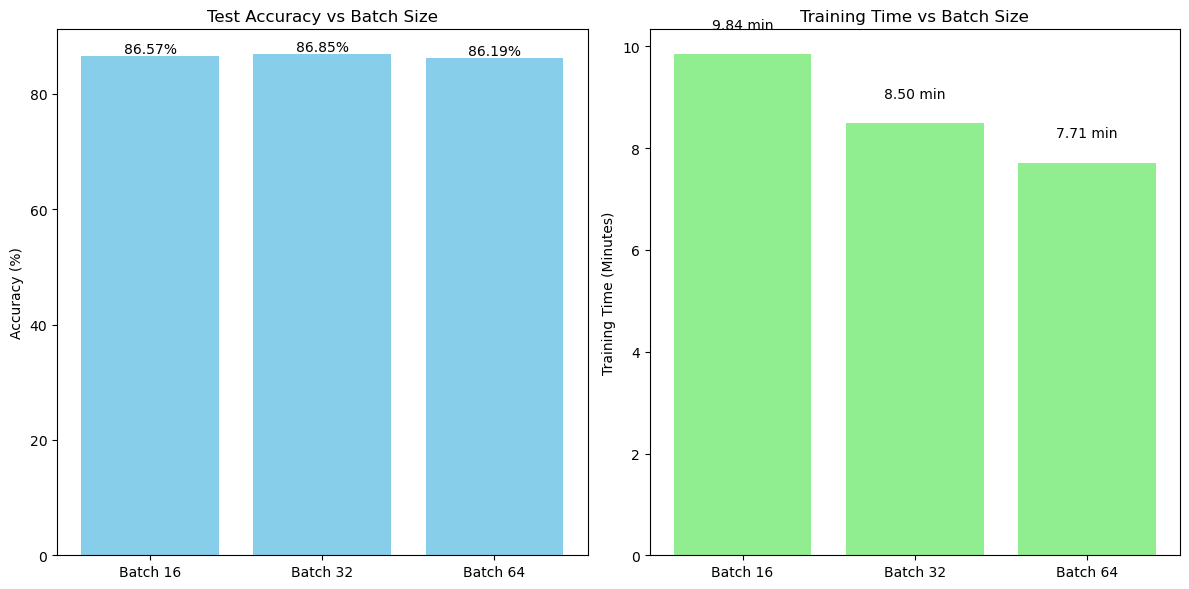

In [4]:
def main():
    batch_sizes = [16, 32, 64]
    results = []

    for batch_size in batch_sizes:
        logging.info(f"Training with batch size {batch_size}...")
        result = train_and_evaluate_with_batch_size("../../preprocessed_glaucoma_data", batch_size)
        results.append(result)

    # Plotting the comparison of batch sizes
    batch_sizes_labels = [f'Batch {r["batch_size"]}' for r in results]
    accuracies = [r['test_accuracy'] for r in results]
    training_times = [r['training_time'] / 60 for r in results]  # Convert to minutes

    # Plotting Accuracy
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(batch_sizes_labels, accuracies, color='skyblue')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy vs Batch Size')
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.5, f'{acc:.2f}%', ha='center')

    # Plotting Training Time
    plt.subplot(1, 2, 2)
    plt.bar(batch_sizes_labels, training_times, color='lightgreen')
    plt.ylabel('Training Time (Minutes)')
    plt.title('Training Time vs Batch Size')
    for i, time in enumerate(training_times):
        plt.text(i, time + 0.5, f'{time:.2f} min', ha='center')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

As we test different batch sizes (16, 32, and 64), the model's test accuracy remains consistent across the batch sizes, with only slight variations:

Batch 16: Accuracy of 86.57

**Batch 32: Accuracy of 86.85%**

Batch 64: Accuracy of 86.19%

The training time, however, increases as the batch size grows. The largest batch size, 64, completes in 7.71 minutes, which is faster compared to batch 16 (9.84 minutes), but it might not scale well with CPUs, especially due to potential limitations in parallel processing.

Given that the accuracy remains relatively constant, I have opted for batch size 32. This choice strikes a balance between faster training time and optimal parallelization on CPUs, where batch size 64 might introduce inefficiencies in computation. This batch size (32) ensures that the model performs well while also benefiting from faster training times.